In [3]:
import folium
from folium.plugins import HeatMap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import re
import string
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sodapy import Socrata


# Predicting if an Animal will be re-homed in <30 Days Using Government Data.

Below is a mini-project I started that attempts to predict if an animal taken in from Austin animal shelter will be re-homed in 30 days. I did this to better understand Tree + Ensemble methods in Sklearn.

- This project was inspired by a [mini-course on decision trees from AWS](https://github.com/aws-samples/aws-machine-learning-university-dte).
- Raw data is taken from [The City of Austin Texas's government data page](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm).

This project is ongoing, please excuse any grammatical mistakes or unfinished parts!

### Ongoing goals to add (As of 4/13/22):

1. Pull data via SODA API or create local SQL server to perform pulls. Problematic as SODA API won't let me pull "max rows."
2. Attempt other ensemble methods. Ideally ADA boosted trees and NN (when I master this).
3. Finish with fine tuning and assessing over test set.
4. Create final table of results + takeaways.
5. Expand on EDA, clean up as part of presentation to Austin Shelter team.
6. **NEW 7/2022** Clean up coding syntax


## Data Intake + Prep

Cleaning is one of the most important aspects of any project. Below I attempt to:

1. Pull in data via API, create datasets
2. Find missing or bad data, these rows could skew our analysis, especially if features contain many missing values or behave in unexpected ways.
3. Apply cleaning rules to data.
4. Merged datasets to have a beginning endline dataset to run EDA over.

---


### 1. Grab Data


In [4]:
# Define way to create raw data from API
def data_feeder(df):
    a = pd.DataFrame.from_records(df)
    a.columns = a.iloc[0]
    a = a[1:]
    # Annoying feature of from_records is that it replaces NaN with ''
    a = a.replace('', np.nan)
    return a


In [5]:
# Call API to get Data
client = Socrata("data.austintexas.gov", 'HwnJIRk3Ph7NqQ0cPB0MOPkTF')
intake = client.get("wter-evkm", limit=99999999, content_type='csv')
outcome = client.get("9t4d-g238", limit=99999999, content_type='csv')

# Make data
intake_df = data_feeder(intake)
outcome_df = data_feeder(outcome)
geocoded_df = pd.read_csv('geocoded_locations.csv')


In [6]:
a = pd.DataFrame.from_records(outcome)
a.columns = a.iloc[0]
a = a[1:]
# Annoying feature of from_records is that it replaces NaN with ''
a = a.replace('', np.nan)


### 2. Find bad/missing data:

Here I am looking for any columns that might be problematic to our analysis (many missing values, extreme values, or nonsensical values that require more digging).

I want to automate this, if we find a small amount of NaN's we should be fine to just drop them. If these NaN become a larger issues (lets say > %2) we need to pause and manually inspect what is going on.

It should be noted that this notebook is a little backwards, I was able to do a mix of EDA and bad data cleanup in unison but for clarity to an external audience I just separate the two. This means I found odd relationships later into EDA but came back up here to insert cleaning rules.


In [7]:
# Let's make a function to output what's missing
def percent_missing(df):
    percent_nan = 100 * df.isnull().sum() / len(df)
    percent_nan = percent_nan[percent_nan > 0].sort_values()
    drop_list = percent_nan[(percent_nan < 2) & percent_nan != 0]
    if percent_nan.shape[0] == 0:
        print("No NA values, consider checking the data")
    else:
        print(percent_nan)
    return drop_list.index.to_list()


intake_drop = percent_missing(intake_df)
outcome_drop = percent_missing(outcome_df)


0
name    29.41981
dtype: float64
0
outcome_type        0.015453
name               29.386436
outcome_subtype    54.122151
dtype: float64


In [8]:
# Clean Data
def lower_case_col(columns):
    return columns.replace(" ", "_").lower()


def sort_for_merge(var, name):
    return var.sort_values(by=[name + '_datetime']).groupby(['animal_id']).cumcount()+1


def clean_up(dataframe, droplist, name):
    return (dataframe
            .rename(columns=lower_case_col)
            .assign(name_avail=np.where(dataframe.name.isna(), 0, 1),
                    datetime=pd.to_datetime(dataframe.datetime),
                    month=lambda x: x.datetime.dt.month
                    )
            .dropna(subset=droplist)
            .rename(columns={'datetime': name+'_datetime'})
            .drop(['name'], axis=1)

            )


In [9]:
# Apply to Data
intake_df_clean = clean_up(intake_df, intake_drop, 'intake')
outcome_df_clean = clean_up(outcome_df, outcome_drop, 'outcome')


### 3. Merge Intake & Outcome Data:

Now merge the semi-cleaned data together so I can continue with feature engineering and EDA. To do this I first create merging variables.

The same animal can show up multiple times, however their intake and subsequent outcome are always in order. For instance if dog A has been intaken 5 times in our data, then they'll be in the outcome 5 times, if not the animal is still waiting for an outcome. I can't merge these multiple instances on ID and date as an animal will come in a different date it leaves, but I can sort on date in both dataframes and create a unique merge variable instead.


In [10]:
def sort_for_merge(var):
    var['merge_counter'] = var.sort_values(
        by=([col for col in var.columns if 'datetime' in col])).groupby(['animal_id']).cumcount()+1


sort_for_merge(intake_df_clean)
sort_for_merge(outcome_df_clean)

# Now merge
merged_df = intake_df_clean.merge(outcome_df_clean[[
    'outcome_type',
    'animal_id',
    'outcome_datetime',
    'merge_counter']],
    on=['animal_id',
        'merge_counter'],
    how='outer',
    indicator=True)

# Okay most merged!
print(merged_df._merge.value_counts())

# lets just keep in the inner product
merged_df = merged_df[merged_df._merge == 'both']


both          141418
left_only       1156
right_only       925
Name: _merge, dtype: int64


## EDA + Feature Engineering

This step attempts to combine multiple aspects of any data science project together:

1. Identify worthwhile features to use and determine what features to create.
2. Create new features. Many of the raw features given are not ready to run EDA over. I need to still fix and create features.
3. Perform EDA and identify any issues or interesting relationships.
4. Drop observations or clean features of interest.
5. Specify features types and transform as needed

Feature Engineering is an ongoing process however, so what is listed above is only a portion of what I do on this project. Moreover, this process is an overarching step of this project. Under the hood and behind the curtains lies hundreds of lines of depreciated code, useless features, and other analysis not included. Later on I will continue feature engineering by dummying our variables (after EDA).

---


### 1.Identify

First I need to think of what features in the intake data could potentially predict if an animal will be rehomed, I don't want to throw the whole kitchen sink of features in potentially adding noise to my analysis. Second, I need to understand and define "rehomed." What is the key performance metric I should use?

Much of this "Identify" comes during EDA or via simple inspection of my data. I already know by looking that intake Age is important, breed, and time of adoption.


### 2. Create

After Identifying what I could use in the intake data, I need to create additional features and retool existing ones to my liking. Some potential ideas I saw:

1. Seasonality might matter, having an animal come in near Christmas might spur higher adoptions.
2. Age needs to be standard across animals, lets turn it into months.
3. How should we deal with purebred and mixed animals?


In [11]:
# Lets make age in terms of months
def age_to_num(var):
    num, date = var.split(' ')
    num = int(num)
    if 'year' in date:
        num = num*12
    elif 'week' in date:
        num = num/4
    elif 'day' in date:
        num = num/30
    else:
        num
    if num < 0:
        num = np.nan
    return(num)

#Add more
merged_df = (
    merged_df
    # Few more X's
    .assign(age=merged_df.age_upon_intake.apply(age_to_num),
            # Let's make a "purebred" variable for dogs. This should only really matter for dogs, as for cats "shorthair mix" & "shorthair" for a cat are identical. Moreover, what is the difference between a "cow" and "cow mix?"
            purebred=np.where((merged_df.animal_type == "Dog") & ~(
                merged_df.breed.str.contains("Mix|/")), 1, 0),
            days=(merged_df.outcome_datetime -
                  merged_df.intake_datetime) / np.timedelta64(1, 'D'),
            )
    # Start on Y's
    .assign(adopted=np.where(merged_df.outcome_type.str.contains('Adopt'), 1, 0),
            rehomed=np.where(merged_df.outcome_type.str.contains(
                'Adopt|Rto|Return to Owner'), 1, 0),
            rehomed_in_30_days=lambda x: np.where(
            (x.rehomed == 1) & (x.days <= 30), 1, 0)
            )
)


## EDA


Lets get an idea of where animals are found with an interactive map:


In [12]:
# Maps
def generateBaseMap(default_location=[30, -97.733330], default_zoom_start=10):
    base_map = folium.Map(location=default_location,
                          control_scale=True, zoom_start=default_zoom_start)
    return base_map


basemap = generateBaseMap()

folium.TileLayer('cartodbpositron').add_to(basemap)
folium.Marker(location=[30.2527847, -97.6926073],
              popup='Austin Animal Shelter',
              icon=folium.Icon(color='green', icon='info-sign')).add_to(basemap)
HeatMap(data=geocoded_df[['latitude', 'longitude']].groupby(['latitude', 'longitude']).sum(
).reset_index().values.tolist(), radius=8, max_zoom=13, name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)
basemap


First lets plot animal age by type. As we can see there's a concerning amount of outliers by animal type in our data (that is observations 1.5\*IQR + 3Q). This is something we ought to drop later on.


Text(0.5, 1.0, 'Average Ages of Animals (All)')

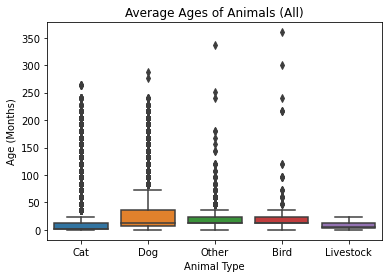

In [14]:
# animal ages
ax = sns.boxplot(x="animal_type", y="age", showfliers=True, data=merged_df)
ax.set_ylabel("Age (Months)")
ax.set_xlabel("Animal Type")
ax.set_title("Average Ages of Animals (All)")



It seems like there's a fair amount of outliers by animal type, lets fix this now before I move on with EDA.


Text(0.5, 1.0, 'Ages without Outliers')

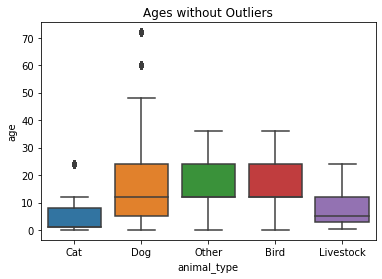

In [15]:
def iqr_drop(df):
    q1 = df.age.quantile(0.25)
    q3 = df.age.quantile(0.75)
    iqr = q3 - q1
    df = df.iloc[np.where((q1 - 1.5*iqr < df.age) &
                          (df.age < q3 + 1.5*iqr))[0], :]
    return df


df = merged_df
for i in merged_df.animal_type.unique():
    q1 = df[df.animal_type == i].age.quantile(0.25)
    q3 = df[df.animal_type == i].age.quantile(0.75)
    iqr = q3 - q1
    drop_q1 = q1 - 1.5*iqr
    drop_q3 = q3 + 1.5*iqr
    df = df.drop(df[(df.animal_type == i) &
                    (df.age < drop_q1)].index)
    df = df.drop(df[(df.animal_type == i) &
                    (df.age > drop_q3)].index)

merged_df_clean = df


ax = sns.boxplot(x="animal_type", y="age",
                 showfliers=True, data=merged_df_clean)
ax.set_title("Ages without Outliers")


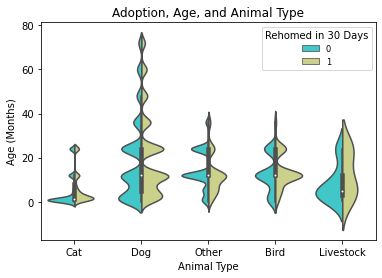

In [16]:
ax = sns.violinplot(x='animal_type', y="age", data=merged_df_clean,
                    hue='rehomed_in_30_days', split='True', palette='rainbow')
ax.set_ylabel("Age (Months)")
ax.set_xlabel("Animal Type")
ax.set_title("Adoption, Age, and Animal Type")
ax.legend(title="Rehomed in 30 Days",
          loc='best', fontsize='small')


In [17]:
table_df = pd.DataFrame()
table_df['Rehomed'] = merged_df_clean['rehomed']
table_df['Rehomed Within 30 Days'] = merged_df_clean['rehomed_in_30_days']
table_df['Animal Type'] = merged_df_clean['animal_type']
table_df['Intake Type'] = merged_df_clean['intake_type']

pivot = np.round(pd.pivot_table(table_df, index=['Animal Type'],
                                values=['Rehomed', 'Rehomed Within 30 Days'],
                                aggfunc=[np.mean, np.sum],
                                margins=True,
                                margins_name='Total'), 2)

pivot


mean                            sum                       
            Rehomed Rehomed Within 30 Days Rehomed Rehomed Within 30 Days
Animal Type                                                              
Bird           0.41                   0.39     270                    258
Cat            0.52                   0.29   23984                  13426
Dog            0.75                   0.64   52810                  45003
Livestock      0.68                   0.32      17                      8
Other          0.10                   0.08     736                    561
Total          0.62                   0.47   77817                  59256

In [18]:
pivot = np.round(pd.pivot_table(table_df, index=['Intake Type'],
                                values=['Rehomed', 'Rehomed Within 30 Days'],
                                aggfunc=[np.mean, np.sum],
                                margins=True,
                                margins_name='Total'), 2)

pivot


mean                            sum  \
                   Rehomed Rehomed Within 30 Days Rehomed   
Intake Type                                                 
Abandoned             0.68                   0.47     530   
Euthanasia Request    0.11                   0.05      11   
Owner Surrender       0.70                   0.54   16598   
Public Assist         0.80                   0.73    5538   
Stray                 0.63                   0.47   55133   
Wildlife              0.00                   0.00       7   
Total                 0.62                   0.47   77817   

                                           
                   Rehomed Within 30 Days  
Intake Type                                
Abandoned                             372  
Euthanasia Request                      5  
Owner Surrender                     12789  
Public Assist                        5084  
Stray                               41000  
Wildlife                                6  
Total                               59256

In [ ]:
sns.countplot(x='animal_type', data=merged_df_clean).set_title(
    "Count of Animal Types")


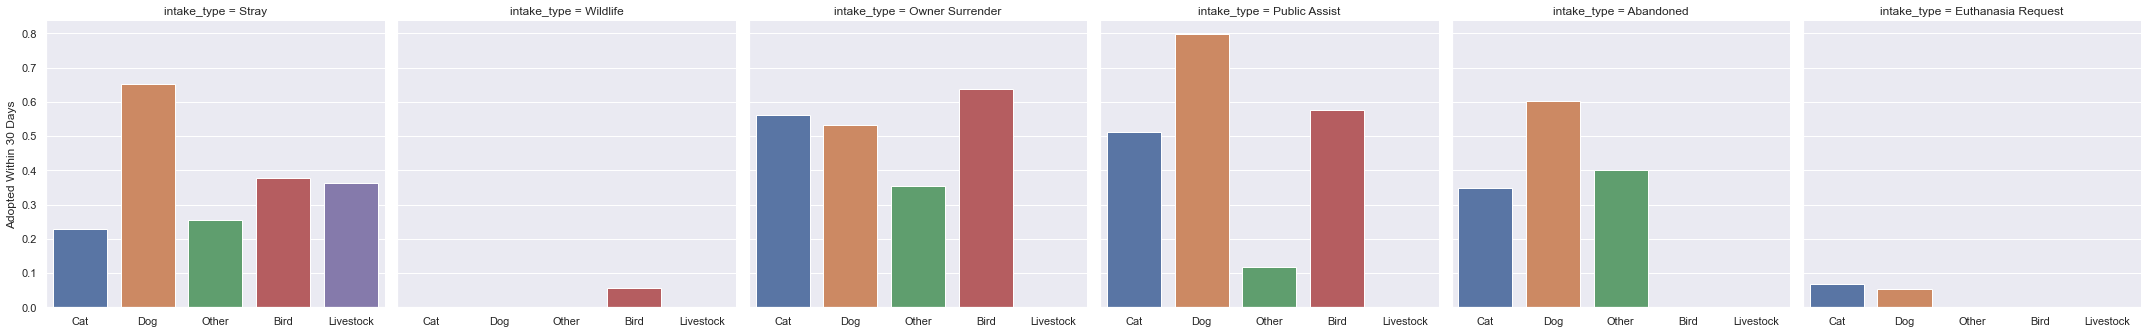

In [19]:
sns.set(style="darkgrid")
ax = sns.catplot(
    x='animal_type',
    y='rehomed_in_30_days',
    col='intake_type',
    data=merged_df_clean,
    kind='bar',
    ci=None
)
ax.set_ylabels('Adopted Within 30 Days')
ax.set_xlabels('')


In [22]:
sns.kdeplot(x='outcome_month',
            data=merged_df_clean,
            fill=True)


ValueError: Could not interpret value `outcome_month` for parameter `x`

In [21]:
def mode(x): return x.mode() if len(x) > 2 else np.array(x)


merged_df_clean.groupby('animal_type')['breed'].agg(mode)


animal_type
Bird                    Chicken Mix
Cat          Domestic Shorthair Mix
Dog                    Pit Bull Mix
Livestock                       Pig
Other                           Bat
Name: breed, dtype: object

In [20]:
merged_df_clean.groupby('animal_type')['breed'].nunique()




animal_type
Bird           82
Cat            85
Dog          2309
Livestock       8
Other         123
Name: breed, dtype: int64

In [121]:


(
    pd
    .get_dummies(merged_df_clean.animal_type)
    .join(merged_df_clean)
    .corr()
    .reset_index()
    .tail(2)
    .style.background_gradient(axis=1, cmap='Greens')
)

merged_df_clean

,animal_id,intake_datetime,datetime2,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,...,merge_counter,outcome_type,outcome_datetime,_merge,age,purebred,days,adopted,rehomed,rehomed_in_30_days
21,A862678,2022-07-29 11:19:00,2022-07-29T11:19:00.000,22801 Hog Eye Rd in Travis (TX),Stray,Neonatal,Cat,Intact Female,1 day,Domestic Shorthair,...,1,Transfer,2022-07-29 13:05:00,both,0.033333,0,0.073611,0,0,0
22,A862679,2022-07-29 11:19:00,2022-07-29T11:19:00.000,22801 Hog Eye Rd in Travis (TX),Stray,Neonatal,Cat,Intact Male,1 day,Domestic Shorthair,...,1,Transfer,2022-07-29 13:05:00,both,0.033333,0,0.073611,0,0,0
49,A862630,2022-07-28 16:16:00,2022-07-28T16:16:00.000,Rowe Lane And Carries Ranch Road in Travis (TX),Stray,Normal,Dog,Intact Female,1 year,Staffordshire Mix,...,1,Return to Owner,2022-07-28 18:19:00,both,12.000000,0,0.085417,0,1,1
69,A862595,2022-07-27 22:02:00,2022-07-27T22:02:00.000,Austin (TX),Wildlife,Normal,Other,Unknown,2 years,Bat,...,1,Disposal,2022-07-28 14:17:00,both,24.000000,0,0.677083,0,0,0
85,A862571,2022-07-27 14:44:00,2022-07-27T14:44:00.000,Northbound 35 Just Past Slaughter in Austin (TX),Stray,Normal,Dog,Intact Male,2 years,Border Collie,...,1,Return to Owner,2022-07-28 15:34:00,both,24.000000,1,1.034722,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142568,A664238,2013-10-01 09:33:00,2013-10-01T09:33:00.000,Outside Jurisdiction,Stray,Normal,Cat,Unknown,4 months,American Shorthair Mix,...,1,Euthanasia,2013-10-01 16:47:00,both,4.000000,0,0.301389,0,0,0
142569,A664233,2013-10-01 08:53:00,2013-10-01T08:53:00.000,7405 Springtime in Austin (TX),Stray,Injured,Dog,Intact Female,3 years,Pit Bull Mix,...,1,Euthanasia,2013-10-01 15:33:00,both,36.000000,0,0.277778,0,0,0
142570,A664235,2013-10-01 08:33:00,2013-10-01T08:33:00.000,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,...,1,Transfer,2013-10-01 10:39:00,both,0.250000,0,0.087500,0,0,0
142571,A664236,2013-10-01 08:33:00,2013-10-01T08:33:00.000,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,...,1,Transfer,2013-10-01 10:44:00,both,0.250000,0,0.090972,0,0,0


### Dealing with Strings

I have a strong interest in using the animal's name, found location, intake type, condition, breed, and color in our analysis. First I need to actually clean the text before I can vectorize them.

As a note: This portion was heavily inspired by the AWS course where they introduced me to text cleaning and vectorization tools.

What I have in mind is this:

1. Use SnowballStemmer to simplify longer strings like colors, address, or name
2. Get rid of useless characters such as "/" "\*" "()" "." in strings
3. Remove any white space


In [ ]:
# First SnowballStemmer

# specify stop_words: words that can be ignored when simplifying our strings
stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]

stemmer = SnowballStemmer('english')


def preProcessText(text):
    # lowercase and strip leading/trailing white space
    text = text.lower().strip()

    # remove HTML tags
    text = re.compile('<.*?>').sub('', text)

    # remove punctuation
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)

    # remove extra white space
    text = re.sub('\s+', ' ', text)

    return text


def lexiconProcess(text, stop_words, stemmer):
    filtered_sentence = []
    words = text.split(" ")
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(stemmer.stem(w))
    text = " ".join(filtered_sentence)

    return text


def cleanSentence(text, stop_words, stemmer):
    return lexiconProcess(preProcessText(text), stop_words, stemmer)


# Clean the text features
for c in ['name', 'breed', 'color', 'found_location', 'intake_condition']:
    print('Text cleaning: ', c)
    merged_df_clean[c] = [cleanSentence(
        item, stop_words, stemmer) for item in merged_df_clean[c].values]
    merged_df[c] = [cleanSentence(item, stop_words, stemmer)
                    for item in merged_df[c].values]


## Feature Selection & Train Test Split


### Selecting Features + Outcome:

After EDA and some manual observation I believe I found a set of interesting features to use to predict adoption and rehoming. To simplfy this process down the road I will specify three type of features that I will use (and subsequently clean).

1. Numerical: Any feature that is continuos or ordinal, i.e. the feature is coded in such a way that high or lower values correspond to some implicit ordering or intensity. Think age, income, weight, size, etc..
2. Categorical: Any feature that can be broken in discrete values, however unlike ordinal, higher or lower values do not correspond to any ordering or intensity. Think color, breed, etc..
3. String: Any feature whose information is encoded as a string, where no well defined structure is present. Think name, address, review, etc..


In [23]:
merged_df_clean.columns


Index(['animal_id', 'intake_datetime', 'datetime2', 'found_location',
       'intake_type', 'intake_condition', 'animal_type', 'sex_upon_intake',
       'age_upon_intake', 'breed', 'color', 'name_avail', 'month',
       'merge_counter', 'outcome_type', 'outcome_datetime', '_merge', 'age',
       'purebred', 'days', 'adopted', 'rehomed', 'rehomed_in_30_days'],
      dtype='object', name=0)

In [24]:
num_feats = ['age', 'merge_counter']
cat_feats = ['animal_type', 'intake_month',
             'sex_upon_intake', 'intake_condition', 'purebred']
# Include color + breed in strings as these features contain multiple values that can be seemingly mixed up. I don't want to treat a pit-bull/lab mix any differently as a lab/put-bull mix.
str_feats = ['name', 'color', 'breed', 'found_location']


In [ ]:
# Lets specify our Y for now:
x = num_feats + cat_feats + str_feats
y = 'rehomed_in_30_days'


In [ ]:
train_data, test_data = train_test_split(
    merged_df, test_size=0.2, shuffle=True, random_state=1)

# From the test data further split into validation (we use throughout process) & test (use only at end)
val_data, test_data = train_test_split(
    test_data, test_size=0.5, shuffle=True, random_state=1)


Let's ensure the training and test data have an equal size amount of outcomes to train over.


In [ ]:
outcome_0_train = train_data[train_data[y] == 0]
outcome_1_train = train_data[train_data[y] == 1]

print(f'Class 0 in Training proportion is: {len(outcome_0_train)}')
print(f'Class 1 in Training proportion is: {len(outcome_1_train)}')

outcome_0_test = test_data[test_data[y] == 0]
outcome_1_test = test_data[test_data[y] == 1]

print(f'Class 0 in Testing proportion is:{len(outcome_0_test)}')
print(f'Class 1 in Testing proportion is:{len(outcome_1_test)}')


In [ ]:
upsampled_class_1_no = outcome_1_train.sample(
    n=len(outcome_0_train), replace=True, random_state=1)
train_data = pd.concat([outcome_0_train, upsampled_class_1_no])
train_data = train_data.sample(frac=1).reset_index(drop=True)

outcome_0_train = train_data[train_data[y] == 0]
outcome_1_train = train_data[train_data[y] == 1]

print(f'Class 0 in Training proportion is: {len(outcome_0_train)}')
print(f'Class 1 in Training proportion is: {len(outcome_1_train)}')


## Process Data + Build Pipline

Below we will process our data (transform categorical into dummies and vectorize text data), then create a pipeline that can take in any new data and work it into our models seamlessly.

For numerical values we'll:

1. Impute any missing values with the mean (we saw very early on not many age's were missing, so a simple imputation will work well)
2. Standardize values (for non-tree models)

For categorical we'll:

1. Impute any missing with a unique categorical value (missing column = 1)
2. Transform into dummies with onehotencoder.

For Strings we'll:

1. Vectorize (just like creating dummies that equal 1 if the word exist in the row)


In [ ]:
num_pipe_tree = Pipeline([
    ('num_tree_imputer', SimpleImputer(strategy='mean'))
])

num_pipe = Pipeline([
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('standardize', StandardScaler())
])

cat_pipe = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='constant',
                                  fill_value='missing')),
    ('coder', OneHotEncoder(handle_unknown='ignore'))
])


text_pipe_name = Pipeline([
    ('text_vect_name', CountVectorizer(binary=True, max_features=50))
])
text_pipe_location = Pipeline([
    ('text_vect_name', CountVectorizer(binary=True, max_features=150))
])
text_pipe_breed = Pipeline([
    ('text_vect_name', CountVectorizer(binary=True))
])
text_pipe_color = Pipeline([
    ('text_vect_name', CountVectorizer(binary=True, max_features=50))
])


# Put all into a single transformer
tree_transformer = ColumnTransformer([
    ('numerical_transform', num_pipe_tree, num_feats),
    ('categorical_transform', cat_pipe, cat_feats),
    ('text_transform_name', text_pipe_name, str_feats[0]),
    ('text_transform_color', text_pipe_color, str_feats[1]),
    ('text_transform_breed', text_pipe_breed, str_feats[2]),
    ('text_transform_loc', text_pipe_location, str_feats[3])

])

logit_transformer = ColumnTransformer([
    ('numerical_transform', num_pipe, num_feats),
    ('categorical_transform', cat_pipe, cat_feats),
    ('text_transform_name', text_pipe_name, str_feats[0]),
    ('text_transform_color', text_pipe_color, str_feats[1]),
    ('text_transform_breed', text_pipe_breed, str_feats[2]),
    ('text_transform_loc', text_pipe_location, str_feats[3])
])


### Specify Models to Run


In [ ]:
# Get train data to train the network
X_train = train_data[x]
y_train = train_data[y]

# Get validation data to validate the network
X_val = val_data[x]
y_val = val_data[y]

# Get test data to test the network
X_test = test_data[x]
y_test = test_data[y]

print('Datasets shapes before processing: ',
      X_train.shape, X_val.shape, X_test.shape)

a = tree_transformer.fit_transform(X_train)
b = tree_transformer.transform(X_val)
c = tree_transformer.transform(X_test)

print('Datasets shapes after processing: ', a.shape, b.shape, c.shape)


In [ ]:
# Classic Tree
classic_tree = DecisionTreeClassifier(random_state=1)
classic = Pipeline([
    ("preprocessor", tree_transformer),
    ("classic_tree", classic_tree)
])

# Random Tree
rfc_tree = RandomForestClassifier(random_state=1)
rfc = Pipeline([
    ("preprocessor", tree_transformer),
    ("rfc_tree", rfc_tree)
])

# Random Tree
ada_tree = AdaBoostClassifier(random_state=1)
ada = Pipeline([
    ("preprocessor", tree_transformer),
    ("ada_tree", ada_tree)
])


# log
log = Pipeline([
    ("preprocessor", logit_transformer),
    ("log", LogisticRegression(max_iter=1000000000000))
])

# regularized log
log_l2_pipe = Pipeline([
    ("preprocessor", logit_transformer),
    ("log", LogisticRegression(penalty='l2',
                               solver='saga',
                               C=.01,
                               max_iter=1000))])


In [ ]:
from sklearn import set_config
set_config(display='diagram')
rfc


## Fit & Run Naive Models


In [ ]:
rfc.fit(X_train, y_train)
classic.fit(X_train, y_train)
ada.fit(X_train, y_train)
log.fit(X_train, y_train)
log_l2_pipe.fit(X_train, y_train)


In [ ]:
rfc_tree.get_params(deep=True)


In [ ]:
train_predictions_rfc = rfc.predict(X_val)
print("RFC TREE:", classification_report(y_val, train_predictions_rfc))
train_predictions_class = classic.predict(X_val)
print("DECISION TREE:", classification_report(y_val, train_predictions_class))
train_predictions_ada = ada.predict(X_val)
print("ADA TREE:", classification_report(y_val, train_predictions_ada))
train_predictions_log = log.predict(X_val)
print("LOG:", classification_report(y_val, train_predictions_log))
train_predictions_log_l2 = log_l2_pipe.predict(X_val)
print("LOG L2:", classification_report(y_val, train_predictions_log_l2))


In [ ]:
a = list(rfc['preprocessor'].transformers_[1][1]
         ['coder'].get_feature_names(cat_feats))
b = list(sorted(rfc['preprocessor'].transformers_[2]
         [1]['text_vect_name'].vocabulary_.keys()))
c = list(sorted(rfc['preprocessor'].transformers_[3]
         [1]['text_vect_name'].vocabulary_.keys()))
d = list(sorted(rfc['preprocessor'].transformers_[4]
         [1]['text_vect_name'].vocabulary_.keys()))
e = list(sorted(rfc['preprocessor'].transformers_[5]
         [1]['text_vect_name'].vocabulary_.keys()))

cols = ['age'] + a + b + c + d + e

coef_tree = pd.DataFrame({'features': cols, 'values': rfc_tree.feature_importances_}).sort_values(
    by='values', ascending=False)


In [ ]:
fig, ax = plt.subplots()
coef_tree.head(10).plot.bar(x='features', ax=ax)
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_title("Feature importances using GINI")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()


### Fine-tuning Hyperparameter


Classic Tree:


In [ ]:
# Parameter grid for GridSearch
param_grid = {'classic_tree__max_depth': [25, 100, 300],  # , 50, 75, 100, 125, 150, 200, 250],
              'classic_tree__min_samples_leaf': [5, 10, 15],  # , 25, 30],
              # , 25, 30, 45, 50]
              'classic_tree__min_samples_split': [2, 5, 15]
              }

grid_search = GridSearchCV(classic,  # Base model
                           param_grid,  # Parameters to try
                           cv=5,  # Apply 5-fold cross validation
                           verbose=1,  # Print summary
                           n_jobs=-1  # Use all available processors
                           )

# Fit the GridSearch to our training data
grid_search.fit(X_train, y_train)


In [ ]:
print(grid_search.best_params_)
print(grid_search.best_score_)
classifier = grid_search.best_estimator_
classifier.fit(X_train, y_train)


In [ ]:
val_predictions = classifier.predict(X_val)
print('Model performance on the train set:')
print(confusion_matrix(y_val, val_predictions))
print(classification_report(y_val, val_predictions))
print("val accuracy:", accuracy_score(y_val, val_predictions))


Random Forest


In [ ]:
# gridsearch cv on random forest

# Parameter grid for GridSearch
param_grid = {'rfc_tree__n_estimators': [150],  # , 50, 75, 100, 125, 150, 200, 250],
              'rfc_tree__max_features': [.2, .5, 1.0, 'auto'],  # , 25, 30],
              # , 50, 75, 100, 125, 150, 200, 250],
              'rfc_tree__max_depth': [3, 10, 100],
              'rfc_tree__min_samples_split': [2, 5, 50]  # , 25, 30, 45, 50]
              }


grid_search = GridSearchCV(rfc,  # Base model
                           param_grid,  # Parameters to try
                           cv=5,  # Apply 5-fold cross validation
                           verbose=10,  # Print summary
                           )

# Fit the GridSearch to our training data
grid_search.fit(X_train, y_train)


In [ ]:
print(grid_search.best_params_)
print(grid_search.best_score_)
classifier = grid_search.best_estimator_
classifier.fit(X_train, y_train)
val_predictions = classifier.predict(X_val)

print('Model performance on the train set:')
print(confusion_matrix(y_val, val_predictions))
print(classification_report(y_val, val_predictions))
print("val accuracy:", accuracy_score(y_val, val_predictions))


ADABoosted Trees


In [ ]:
# gridsearch cv on random forest

# Parameter grid for GridSearch
param_grid = {'ada_tree__n_estimators': [5, 150, 300],  # , 50, 75, 100, 125, 150, 200, 250],
              'ada_tree__learning_rate': [.5, .1]
              }


grid_search = GridSearchCV(ada,  # Base model
                           param_grid,  # Parameters to try
                           cv=5,  # Apply 5-fold cross validation
                           verbose=10,  # Print summary
                           n_jobs=-1  # Use all available processors
                           )

# Fit the GridSearch to our training data
grid_search.fit(X_train, y_train)


In [ ]:
print(grid_search.best_params_)
print(grid_search.best_score_)
classifier = grid_search.best_estimator_
classifier.fit(X_train, y_train)
val_predictions = classifier.predict(X_val)

print('Model performance on the train set:')
print(confusion_matrix(y_val, val_predictions))
print(classification_report(y_val, val_predictions))
print("val accuracy:", accuracy_score(y_val, val_predictions))


In [ ]:
coef_logit = pd.DataFrame(zip(X_train.columns, np.transpose(
    log.coef_.tolist()[0])), columns=['features', 'coef'])
coef_logit = coef_logit.sort_values(by='coef', ascending=False).reset_index()
coef_logit


In [ ]:
coef_tree = pd.DataFrame(
    X_train.columns, new_tree.feature_importances_, columns=['features'])
coef_tree.sort_index(ascending=False).head(5)


In [ ]:
coef_logit[coef_logit['features'].str.contains('Pit')]


In [ ]:
coef_ada = pd.DataFrame(zip(X_train.columns, np.transpose(
    rfc_tree.feature_importances_)), columns=['features', 'coef'])
coef_ada = coef_ada.sort_values(by='coef', ascending=False).reset_index()
coef_ada


In [ ]:

print(classification_report(y_predict, y_test))
plot_confusion_matrix(log, Scaler.transform(X_test), y_test, normalize='true')
